In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime
from math import ceil

**Read listings_al.csv**, which has the dates needed for the listings fact table.

In [2]:
listings_al_file_path = '../data/listings_al.csv'
df_listings = pd.read_csv(listings_al_file_path,sep=',')

C:\Users\joao_\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (61,62) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


**Read calendar.csv file**, which has the dates needed for the availability fact table.

In [3]:
calendar_file_path = '../data/airbnb/calendar.csv'
df_calendar = pd.read_csv(calendar_file_path,sep=',')

Convert string to date

In [4]:
df_listings['DataRegisto'] = [datetime.strptime(d.split('.')[0], "%Y-%m-%dT%H:%M:%S") for d in df_listings['DataRegisto']]
df_listings.shape

(17168, 147)

In [5]:
df_calendar['date'] = [datetime.strptime(d, "%Y-%m-%d") for d in df_calendar['date']]
df_calendar.shape

(7190661, 7)

In [6]:
df_calendar.head()

,listing_id,date,available,price,adjusted_price,minimum_nights,maximum_nights
0,286500,2020-02-14,f,$150.00,$150.00,3.0,365.0
1,69042,2020-02-14,f,$130.00,$130.00,3.0,365.0
2,69042,2020-02-15,f,$130.00,$130.00,3.0,365.0
3,69042,2020-02-16,t,$130.00,$130.00,2.0,365.0
4,69042,2020-02-17,f,$130.00,$130.00,2.0,365.0


In calendar.csv there is approximately 365 records for each listing. Each record indicates if the listing is available in that day.

Now lets drop the duplicates from df_calendar. 

In [7]:
df_calendar = df_calendar.drop_duplicates(subset=['date'])
df_calendar.shape

(366, 7)

**EDA**

Lets explore the dates that came from listings_al.csv

In [8]:
years = [d.year for d in df_listings['DataRegisto']]
df_years = pd.DataFrame(years,columns=['year'])
df_years_graph = df_years.year.value_counts().to_frame('count').reset_index().rename(columns={'index': 'year'}).sort_values('year',ascending = True)
#remove data from 2020 because it is incompleted (data exported from inside airbnb in january)
df_years_graph = df_years_graph[df_years_graph['year']!=2020]
#create column with the comulative 
df_years_graph['cum_count'] = df_years_graph['count'].cumsum()

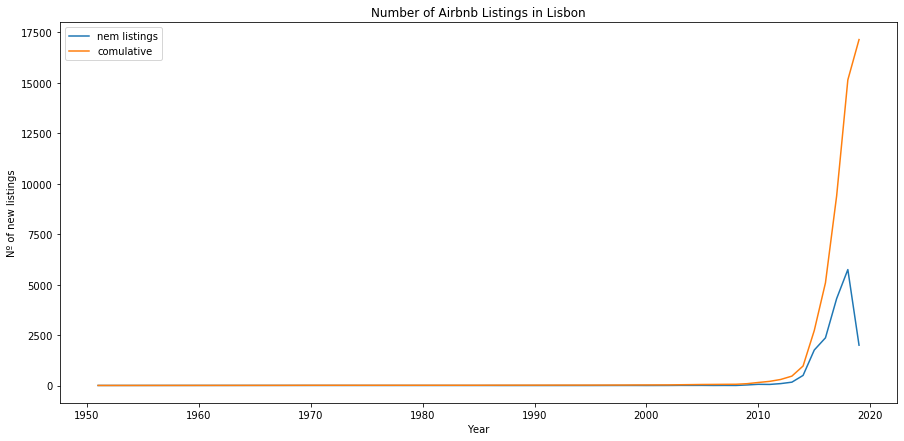

In [9]:
plt.figure(figsize=(15,7))
plt.plot(df_years_graph['year'],df_years_graph['count'], label = 'nem listings')
plt.plot(df_years_graph['year'],df_years_graph['cum_count'], label = 'comulative')
plt.xlabel('Year')
plt.ylabel('Nº of new listings')
plt.title('Number of Airbnb Listings in Lisbon')
plt.legend()

Lets plot the data just from 2010.

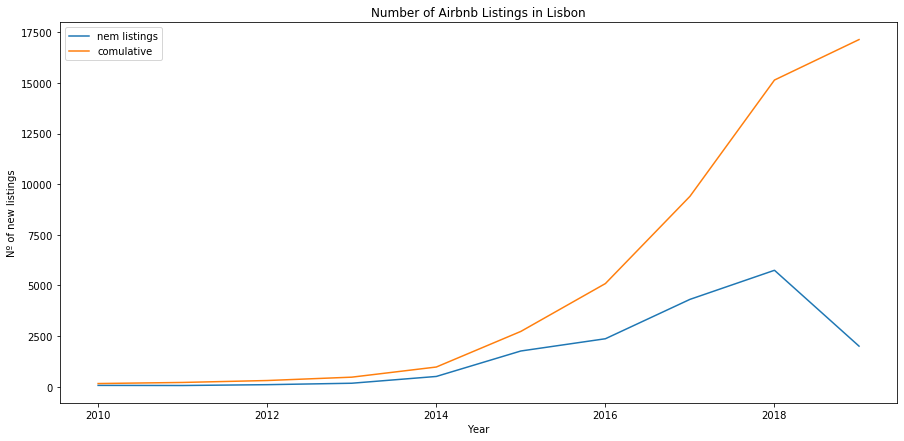

In [10]:
df_years_graph2 = df_years_graph[df_years_graph['year']>= 2010]
plt.figure(figsize=(15,7))
plt.plot(df_years_graph2['year'],df_years_graph2['count'], label = 'nem listings')
plt.plot(df_years_graph2['year'],df_years_graph2['cum_count'], label = 'comulative')
plt.xlabel('Year')
plt.ylabel('Nº of new listings')
plt.title('Number of Airbnb Listings in Lisbon')
plt.legend()

We can see that since 2013, the number of new listings in airbnb for Lisbon increased until 2018, from less than 500 new listings per year to more than 5000 new listings per year, which is a 10x increase. In 2019 the number of new listings decreased compared to the homologue period.

In [11]:
df_years_graph2

,year,count,cum_count
8,2010,60,151
9,2011,54,205
7,2012,95,300
6,2013,166,466
5,2014,501,967
4,2015,1759,2726
2,2016,2364,5090
1,2017,4309,9399
0,2018,5746,15145
3,2019,1999,17144


In 2010 there were 151 listings in airbnb, about Lisbon, and in 2019 there was a total of 17155 listings, which is an increase of about 113 times.

**Preprocessing**

Now lets preprocess in order to create our dimension.

In [23]:
def date_season(month):
    if (month < 3): return 'Winter'
    elif (month >= 3) and (month < 6): return 'Spring'
    elif (month >= 6) and (month < 9): return 'Summer'
    elif (month >= 9) and (month < 12): return 'Autumn'

def date_weekend(week_day):
    if (week_day == 5) or (week_day == 6): return 'Weekend'
    else: return 'Work day'
def week_day(d):
    days = {0: "Monday", 1: "Tuesday", 2: "Wednesday", 3: "Thursday", 4: "Friday", 5: "Saturday", 6: "Sunday"}
    return days[d.weekday()]
def date_pk(date):
    return int(date.strftime('%d%m%Y'))

def week_of_month(dt):
    """ Returns the week of the month for the specified date.
    """
    first_day = dt.replace(day=1)
    dom = dt.day
    adjusted_dom = dom + first_day.weekday()
    return int(ceil(adjusted_dom/7.0))

def getQuarter(d):
    if d.month<=3: return "Q1"
    if d.month<=6: return "Q2"
    if d.month<=9: return "Q3"
    return "Q4"

def getSemester(d):
    if d.month<=6: return "S1"
    return "S2"

Example of date dimension primary key in format 'ddMMyyyy'

In [24]:
df_listings['DataRegisto'][0], date_pk(df_listings['DataRegisto'][0])

(Timestamp('2017-09-13 13:40:58'), 13092017)

**Process the df_listings data**

In [25]:
pks = [date_pk(d) for d in df_listings['DataRegisto']]
days = [d.day for d in df_listings['DataRegisto']]
weeks = [week_of_month(d) for d in df_listings['DataRegisto']]
week_days = [week_day(d) for d in df_listings['DataRegisto']]
week_ends = [date_weekend(d.weekday()) for d in df_listings['DataRegisto']]
months = [d.month for d in df_listings['DataRegisto']]
seasons = [date_season(d.month) for d in df_listings['DataRegisto']]
quarters = [getQuarter(d) for d in df_listings['DataRegisto']]
semesters = [getSemester(d) for d in df_listings['DataRegisto']]

Create dataframe

In [26]:
columns = ['PK','Day','WeekDay', 'Weekend','Week','Month','Season','Year','Quarter','Semester']
df_date_dimension = pd.DataFrame(np.stack((pks,days,week_days,week_ends,weeks,months,seasons,years,quarters,semesters),axis=-1), columns = columns)
df_date_dimension.shape

(17168, 10)

In [27]:
df_date_dimension.head()

,PK,Day,WeekDay,Weekend,Week,Month,Season,Year,Quarter,Semester
0,13092017,13,Wednesday,Work day,3,9,Autumn,2017,Q3,S2
1,15012016,15,Friday,Work day,3,1,Winter,2016,Q1,S1
2,12052016,12,Thursday,Work day,3,5,Spring,2016,Q2,S1
3,31082017,31,Thursday,Work day,5,8,Summer,2017,Q3,S2
4,31082017,31,Thursday,Work day,5,8,Summer,2017,Q3,S2


Remove duplicates

In [28]:
df_date_dimension = df_date_dimension.drop_duplicates(subset=['PK'])
df_date_dimension.shape

(1826, 10)

**Process the df_calendar data**

In [29]:
df_calendar.head()

,listing_id,date,available,price,adjusted_price,minimum_nights,maximum_nights
0,286500,2020-02-14,f,$150.00,$150.00,3.0,365.0
2,69042,2020-02-15,f,$130.00,$130.00,3.0,365.0
3,69042,2020-02-16,t,$130.00,$130.00,2.0,365.0
4,69042,2020-02-17,f,$130.00,$130.00,2.0,365.0
5,69042,2020-02-18,f,$130.00,$130.00,2.0,365.0


In [30]:
pks2 = [date_pk(d) for d in df_calendar['date']]
days2 = [d.day for d in df_calendar['date']]
weeks2 = [week_of_month(d) for d in df_calendar['date']]
week_days2 = [week_day(d) for d in df_calendar['date']]
week_ends2 = [date_weekend(d.weekday()) for d in df_calendar['date']]
months2 = [d.month for d in df_calendar['date']]
seasons2 = [date_season(d.month) for d in df_calendar['date']]
quarters2 = [getQuarter(d) for d in df_calendar['date']]
semesters2 = [getSemester(d) for d in df_calendar['date']]
years2 = [d.year for d in df_calendar['date']]

In [31]:
df_date_dimension = pd.concat([pd.DataFrame(np.stack((pks2,days2,week_days2,week_ends2,weeks2,months2,seasons2,years2,quarters2,semesters2),axis=-1), columns = columns),df_date_dimension])
df_date_dimension

,PK,Day,WeekDay,Weekend,Week,Month,Season,Year,Quarter,Semester
0,14022020,14,Friday,Work day,3,2,Winter,2020,Q1,S1
1,15022020,15,Saturday,Weekend,3,2,Winter,2020,Q1,S1
2,16022020,16,Sunday,Weekend,3,2,Winter,2020,Q1,S1
3,17022020,17,Monday,Work day,4,2,Winter,2020,Q1,S1
4,18022020,18,Tuesday,Work day,4,2,Winter,2020,Q1,S1
...,...,...,...,...,...,...,...,...,...,...
17150,14032013,14,Thursday,Work day,3,3,Spring,2013,Q1,S1
17153,18012020,18,Saturday,Weekend,3,1,Winter,2020,Q1,S1
17155,22012020,22,Wednesday,Work day,4,1,Winter,2020,Q1,S1
17157,21012020,21,Tuesday,Work day,4,1,Winter,2020,Q1,S1
